# Study interpolating resolution matrix

# NOTE: this notebook is deprecated, please run this instead:

```
python plot_interpresolution.py
```

In [1]:
#- non-DESI imports
import os, sys, glob

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import dok_matrix, dia_matrix, csr_matrix, csc_matrix
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import fitsio

from astropy.visualization import ZScaleInterval

plt.ion();

In [2]:
#- DESI imports
import desispec.io
from desispec.io import findfile, read_image, read_frame
from desispec.interpolation import resample_flux
from desispec.resolution import Resolution
from specter.psf import load_psf
from specter.extract import ex2d

In [3]:
specprod = 'fuji'
os.environ['SPECPROD'] = specprod
reduxdir = os.path.expandvars(f'$DESI_ROOT/spectro/redux/{specprod}/preproc/')
night = 20210101
expid = 70350
camera = 'r1'

psf = load_psf(findfile('psf', night, expid, camera))

In [4]:
nspec = 1
dw = 0.8
ww = 7300 + np.arange(50)*dw

subsample = 10
inwave = 7300 + np.arange((len(ww)-1)*subsample+1)*dw/subsample
inphot = 100*np.ones((nspec, len(inwave))) / subsample

inphot[0,10*subsample] += 1000  #- aligned with extraction grid
inphot[0,20*subsample + int(subsample*0.33)] += 1000  #- not aligned with extraction grid
inphot[0,30*subsample + int(subsample*0.50)] += 1000  #- not aligned with extraction grid
inphot[0,40*subsample + int(subsample*0.67)] += 1000  #- not aligned with extraction grid

# mid = 112
# ii = np.arange(mid-20, mid+20)
# inphot[0,ii] += 150*np.exp(-(ii-mid)**2 / (2*(subsample)**2))

xyrange = xmin, xmax, ymin, ymax = psf.xyrange((0,nspec), inwave)
simpix = psf.project(inwave, inphot, xyrange=xyrange)

readnoise = 3.0
imgivar = 1/(simpix + readnoise**2)

In [5]:
def simulate_extractions(simpix, readnoise, n=1000):
    np.random.seed(0)
    multiflux = list()
    multiivar = list()
    for i in range(n):
        simimg = np.random.poisson(simpix) + np.random.normal(scale=readnoise, size=simpix.shape)
        flux, ivar, rdat = ex2d(simimg, imgivar, psf, specmin=0, nspec=1, wavelengths=ww, xyrange=xyrange)
        multiflux.append(flux[0])
        multiivar.append(ivar[0])

    multiflux = np.array(multiflux)
    multiivar = np.array(multiivar)

    rdat = rdat[0]
    R = Resolution(rdat)
    
    return multiflux, multiivar, R, rdat

multiflux, multiivar, R, rdat = simulate_extractions(simpix, readnoise)

## Bias from unresampled delta-function input

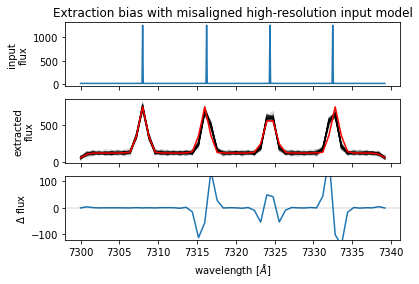

In [6]:
def plot_extraction_bias(inwave, inphot, ww, multiflux, multiivar, R):
    dw = ww[1]-ww[0]
    subsample = int(round(dw / (inwave[1]-inwave[0])))

    ax1 = plt.subplot(311)
    plt.plot(inwave, inphot[0]/dw)
    plt.ylabel('input\nflux')
    ax1.axes.xaxis.set_ticklabels([])

    ax2 = plt.subplot(312)
    for i in range(100):
        plt.plot(ww, multiflux[i], 'k-', lw=1, alpha=0.1)

    inphot2 = resample_flux(ww, inwave, inphot/(dw/subsample))
    plt.plot(ww, R.dot(inphot2), 'r-')
    plt.ylabel('extracted\nflux')
    ax2.axes.xaxis.set_ticklabels([])

    ax3 = plt.subplot(313)
    xflux = np.mean(multiflux, axis=0)
    plt.plot(ww, xflux - R.dot(inphot2))
    plt.axhline(0, color='k', alpha=0.1)
    plt.ylabel(r'$\Delta$ flux')
    plt.xlabel(r'wavelength [$\AA$]');
    plt.ylim(-120, 120)
    
    return ax1, ax2, ax3
    
ax1, ax2, ax3 = plot_extraction_bias(inwave, inphot, ww, multiflux, multiivar, R);
ax1.set_title('Extraction bias with misaligned high-resolution input model')
plt.savefig('exbias-offset-input.pdf')

## Less bias from resolved input, even with wavelength offsets

In [7]:
#- sigma in dw pixels for 100 km/s velocity dispersion
# sigma = 100*ww[0]/3e5 / dw
sigma = 1.0
inphot2 = gaussian_filter(inphot[0], sigma*subsample).reshape(inphot.shape)

simpix2 = psf.project(inwave, inphot2, xyrange=xyrange)
imgivar2 = 1/(simpix2 + readnoise**2)

multiflux2, multiivar2, R2, rdat2 = simulate_extractions(simpix2, readnoise)

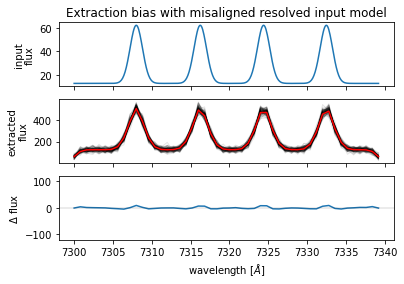

In [8]:
ax1, ax2, ax3 = plot_extraction_bias(inwave, inphot2, ww, multiflux2, multiivar2, R2);
ax1.set_title('Extraction bias with misaligned resolved input model')
plt.savefig('exbias-resolved-input.pdf')

## Resampling the resolution matrix

In [9]:
from scipy.interpolate import Rbf
from scipy.optimize import curve_fit

def g3(x, *args):
    m1, m2, m3, s1, s2, s3, k1, k2, k3 = args
    y  = k1 * np.exp(-(x - m1)**2 / (2 * s1**2))
    y += k2 * np.exp(-(x - m2)**2 / (2 * s2**2))
    y += k3 * np.exp(-(x - m3)**2 / (2 * s3**2))
    return y

def g2(x, *args):
    m1, m2, s1, s2, k1, k2 = args
    y  = k1 * np.exp(-(x - m1)**2 / (2 * s1**2))
    y += k2 * np.exp(-(x - m2)**2 / (2 * s2**2))
    return y

def fit_gauss3(x, xp, yp):
    m = np.sum(xp*yp) / np.sum(yp)
    params = [m,m,m, 1,1,1, 0.3, 0.1, 0.0]
    pfit = curve_fit(g3, xp, yp, p0=params)[0]
    return g3(x, *pfit)

def fit_gauss2(x, xp, yp):
    m = np.sum(xp*yp) / np.sum(yp)
    params = [m,m, 0.6,0.5, 0.4,0.1]
    pfit = curve_fit(g2, xp, yp, p0=params)[0]
    return g2(x, *pfit)

def fit_logspline(x, xp, yp):
    ii = yp>0
    fn = interp1d(xp[ii], np.log(yp[ii]), kind='cubic', fill_value=1e-10, bounds_error=False)
    jj = (xp[ii][0] <= x) & (x <= xp[ii][-1])
    y = np.zeros(len(x))
    y[jj] = np.exp(fn(x[jj]))
    return y

def resample_rdat(wave2, wave1, rdat1):
    """
    resample rdat1 diagonals on wave1 grid to wave2 grid
    
    Returns sparse matrix R21[len(wave1), len(wave2)] that convolves and resamples
    a model on wave2 grid to wave1 grid.
    """
    R1 = Resolution(rdat1).tocsr()
    
    n1 = len(wave1)
    n2 = len(wave2)    
    R2 = np.zeros((n1,n2))
    ndiag = rdat1.shape[0]
    
    for row in range(n1):
        y = R1[row].toarray()[0]
        #--- Linear
        # R2[row] = np.interp(wave2, wave1, y)
        #--- Spline
        fn = interp1d(wave1, y, kind='cubic', fill_value=0.0, bounds_error=False)
        R2[row] = fn(wave2)
        #--- Spline of log(y)
        # R2[row] = fit_logspline(wave2, wave1, y)
        #--- Radial Basis Function
        # fn = Rbf(wave1, y, function='multiquadric')
        # R2[row] = fn(wave2)
        #--- Gaussian fit to core
        # ii = y>1e-2
        # c = gaussfit(wave1[ii], y[ii])
        # R2[row] = gauss(wave2, *c)

    R2 = csc_matrix(R2)
    return R2
    
R1x = resample_rdat(inwave, ww, rdat)

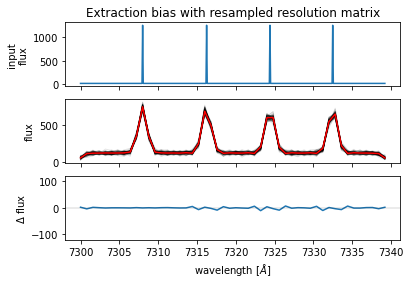

In [10]:
ax1 = plt.subplot(311)
plt.plot(inwave, inphot[0]/dw)
plt.ylabel('input\nflux')
ax1.axes.xaxis.set_ticklabels([])
ax1.set_title('Extraction bias with resampled resolution matrix')

ax2 = plt.subplot(312)
for i in range(100):
    plt.plot(ww, multiflux[i], 'k-', lw=1, alpha=0.1)

plt.plot(ww, R1x.dot(inphot[0]/dw), 'r-')
plt.ylabel('flux')
ax2.axes.xaxis.set_ticklabels([])

ax3 = plt.subplot(313)
xflux = np.mean(multiflux, axis=0)
plt.plot(ww, xflux - R1x.dot(inphot[0]/dw))
plt.axhline(0, color='k', alpha=0.1)
plt.ylabel(r'$\Delta$ flux')
plt.xlabel(r'wavelength [$\AA$]');
plt.ylim(-120, 120)

plt.savefig('exbias-resample-R.pdf')